
# Importing Libraries and Datasets

In [3]:
import math as math
import pandas as pd
import numpy as np
import seaborn as sns
import squarify as sqf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

In [4]:
df_food = pd.read_csv("Food_Production.csv")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
import warnings
warnings.filterwarnings("ignore")

<a id="section-four"></a>
# 4. Feature Engineering

Abbiamo alcuni problemi da risolvere prima di poter procedere:
- Innanzitutto, rinomino le colonne
- In secondo luogo, cerco eventuali valori negativi
- In terzo luogo, gestire eventuali valori mancanti
- In quarto luogo, supponendo che ci siamo assunti il compito di assistere le operazioni scientifiche, ingegneristiche o aziendali, potremmo aver bisogno di effettuare alcune trasformazioni dei dati per assistere i nostri colleghi che avranno sicuramente esigenze diverse (ad es. orientato al processo, ecc.).

<a id="section-four"></a>
## 4.1 Renaming Columns

In [10]:
# The column names in the dataset are quite inconsistent (some use underscores, others spaces, there are letters missing, etc.) and some columns have long names that need to be revisited.

# Creating short dataframes containing a keyword from the various columns
df_eutro = df_food.loc[:, ["Eutro" in i for i in df_food.columns]]
df_freshwater = df_food.loc[:, ["Freshwater" in i for i in df_food.columns]]
df_gas = df_food.loc[:, ["gas" in i for i in df_food.columns]]
df_land = df_food.loc[:, ["Land" in i for i in df_food.columns]]
df_scarc_water = df_food.loc[:, ["Scarcity" in i for i in df_food.columns]]

# Correcting the inconsistent naming patterns and renaming the long-winded columns
df_food.rename(columns = {
    'Food product' : 'Food_Product',
    'Packging' : 'Packaging',
    'Total_emissions' : 'Total_Emissions',
    'Animal Feed' : 'Animal_Feed',
    df_eutro.columns[0] : "Eutro_Em_1000kcal",
    df_eutro.columns[1] : "Eutro_Em_1kg",
    df_eutro.columns[2] : "Eutro_Em_100gProtein",
    df_freshwater.columns[0] : "Freshwater_1000kcal",
    df_freshwater.columns[1] : "Freshwater_100gProtein",
    df_freshwater.columns[2] : "Freshwater_1kg",
    df_gas.columns[0] : "GGas_Em_1000kcal",
    df_gas.columns[1] : "GGas_Em_100gProtein",
    df_land.columns[0] : "Land_Use_Change",
    df_land.columns[1] : "Land_Use_1000kcal",
    df_land.columns[2] : "Land_Use_1kg",
    df_land.columns[3] : "Land_Use_100gProtein",
    df_scarc_water.columns[0] : "ScarcWater_1kg",
    df_scarc_water.columns[1] : "ScarcWater_100gProtein",
    df_scarc_water.columns[2] : "ScarcWater_1000kcal"
}, inplace=True)

print("New column names: \n")
for col in df_food:
    print(col)

New column names: 

Food_Product
Land_Use_Change
Animal_Feed
Farm
Processing
Transport
Packaging
Retail
Total_Emissions
Eutro_Em_1000kcal
Eutro_Em_1kg
Eutro_Em_100gProtein
Freshwater_1000kcal
Freshwater_100gProtein
Freshwater_1kg
GGas_Em_1000kcal
GGas_Em_100gProtein
Land_Use_1000kcal
Land_Use_1kg
Land_Use_100gProtein
ScarcWater_1kg
ScarcWater_100gProtein
ScarcWater_1000kcal


Low number of unique values?

On a secondary nature, it would be a fair assumption to expect different food products to have different CO2 emission measurements for certain features/columns like [Retail], [Transport], [Packaging], and [Animal Feed]. However, they have a surprising low amount of unique values, as can be seen in the following cell.

In [11]:
print("Unique values - standardized agriculture operations: " + "\n\n"
    + str(df_food[["Retail", "Transport", "Packaging", "Animal_Feed"]].nunique()) + "\n\n"
    + "Top 10 Retail Values for Food Products" + "\n"
    + str(df_food[['Food_Product', 'Retail', 'Transport']].sort_values(by='Retail', ascending=False).head(10)))

Unique values - standardized agriculture operations: 

Retail          4
Transport       8
Packaging      10
Animal_Feed    10
dtype: int64

Top 10 Retail Values for Food Products
         Food_Product  Retail  Transport
13            Soymilk     0.3        0.1
2       Barley (Beer)     0.3        0.0
39             Cheese     0.3        0.1
38               Milk     0.3        0.1
14               Tofu     0.3        0.2
42   Shrimps (farmed)     0.2        0.2
37       Poultry Meat     0.2        0.3
36           Pig Meat     0.2        0.3
35      Lamb & Mutton     0.2        0.5
34  Beef (dairy herd)     0.2        0.4


<a id="section-four"></a>
## 4.2 Addressing Negative Values

In [12]:
# First, let us scout for negative values in our dataset and, if detected, determine how to proceed with the analysis.

df_numeric = df_food.select_dtypes('number')
neg_values = (df_numeric<0).sum().sum()

print(f"Number of negative values in the dataset: {neg_values}")

Number of negative values in the dataset: 4


In [13]:
# It would appear that only only column holds negative values: Land-Use Change

(df_numeric<0).sum().sort_values(ascending=False).head(3)

Land_Use_Change           4
Animal_Feed               0
ScarcWater_100gProtein    0
dtype: int64

In [14]:
# There are four entries of food products in Land-Use Change that hold negative values.

df_food[df_food['Land_Use_Change']<0][['Food_Product', 'Land_Use_Change']]

,Food_Product,Land_Use_Change
11,Nuts,-2.1
19,Olive Oil,-0.4
25,Citrus Fruit,-0.1
29,Wine,-0.1


Negative values will hinder our ability to properly visualize the data.

Therefore we shall proceed with the following choices:
1. Made a note of our discovery and provided scientific evidence regarding its presence.
2. Replace all negative values with zero so we can proceed with the analysis.

In [15]:
# We can iterate through the columns in our dataframe that hold numeric values in order to detect and replace all negative values with zero

for col in df_food.iloc[:, df_food.columns.get_loc('Land_Use_Change'):df_food.columns.get_loc('ScarcWater_1000kcal')]:
    for ind, entry in enumerate(df_food[col]):
        if entry < 0:
            df_food.at[ind, col] = 0
print(f"Number of negative values in the dataset: {((df_food.iloc[:,1:-1])<0).sum().sum()}")

Number of negative values in the dataset: 0


In [16]:
# Creating a food category column which we will retain for all following sections of this analysis.

df_food["Category"] = df_food["Food_Product"] # creating a new column with the exact list of [Food_Products]

# Setting various lists for different types of [Food_Products]
Grains = ["Wheat & Rye (Bread)", "Maize (Meal)", "Oatmeal", "Barley (Beer)", "Rice"]
Nuts = ['Nuts', 'Groundnuts']
Vegetables = ["Potatoes", "Cassava", 'Other Pulses',"Peas",'Tomatoes', 'Onions & Leeks','Root Vegetables',"Brassicas",'Other Vegetables']
Fruits = ['Citrus Fruit', 'Bananas','Apples', 'Berries & Grapes', 'Other Fruit']
Sugars = ['Cane Sugar', 'Beet Sugar',]
Oils = ['Soybean Oil', 'Palm Oil', 'Sunflower Oil', 'Rapeseed Oil', 'Olive Oil']
Dairy = ["Soymilk",'Milk', 'Cheese']
Animal_Prod = ['Beef (beef herd)', 'Beef (dairy herd)','Lamb & Mutton', 'Pig Meat', 'Poultry Meat', 'Eggs', 'Fish (farmed)', 'Shrimps (farmed)']
Other = ["Tofu", "Coffee", "Dark Chocolate", "Wine"]

# Replacing all [Food_Products] in the newly developed column with their respective food [Category]
for i in df_food["Category"]:
    if i in Grains:
        df_food["Category"].replace([i], "Grains", inplace=True)
    elif i in Nuts:
        df_food["Category"].replace([i], "Nuts", inplace=True)
    elif i in Vegetables:
        df_food["Category"].replace([i], "Vegetables", inplace=True)
    elif i in Fruits:
        df_food["Category"].replace([i], "Fruits", inplace=True)
    elif i in Sugars:
        df_food["Category"].replace([i], "Sugar", inplace=True)
    elif i in Oils:
        df_food["Category"].replace([i], "Oils", inplace=True)
    elif i in Dairy:
        df_food["Category"].replace([i], "Dairy", inplace=True)
    elif i in Animal_Prod:
        df_food["Category"].replace([i], "Animal_Prod", inplace=True)
    elif i in Other:
        df_food["Category"].replace([i], "Other", inplace=True)

#### 1) Dropping columns with missing values

In [19]:
# Dropping NA values would be easy thing to do, however, it might not be the most scientific approach.

diff = round((len(df_food.dropna())/len(df_food))*100, ndigits=2)
             
print("Number of rows in original dataset: " + str(len(df_food)) + "\n"
      "Number of rows after dropping NA values: " + str(len(df_food.dropna())) + "\n"
      "Percentage difference: " + "%" + str(diff))

# Indeed, if we choose to drop NA values we would lose a staggesting 55.8% of the observations (rows) in our original dataset.

Number of rows in original dataset: 43
Number of rows after dropping NA values: 24
Percentage difference: %55.81


#### 2) Imputation by average value (mean)

L'imputazione che utilizza la media o la mediana sono due approcci univariati particolarmente apprezzati per la loro facilità di implementazione e nel nostro caso sono decisamente un gradino sopra il metodo precedente di eliminare semplicemente tutte le colonne con valori mancanti.

In [20]:
# Mean Imputation

df_mean = df_food.copy(deep=True)

df_mean = df_mean.fillna(df_mean.mean())
df_mean_na_sum = df_mean.isna().sum().sum()

print(f"Method: Mean Imputation \n" 
      + f"Number of missing values in dataset: {df_mean_na_sum} \n\n"
      + f"Mean value in Eutro_Em_1000kcal: {round(df_mean['Eutro_Em_1000kcal'].mean(),2)} \n"
      + f"Mean value in Freshwater_100gProtein: {round(df_mean['Freshwater_100gProtein'].mean(),2)} \n"
      + f"Mean value in Eutro_Em_100gProtein: {round(df_mean['Eutro_Em_100gProtein'].mean(),2)}")

Method: Mean Imputation 
Number of missing values in dataset: 0 

Mean value in Eutro_Em_1000kcal: 27.18 
Mean value in Freshwater_100gProtein: 1437.98 
Mean value in Eutro_Em_100gProtein: 52.77


In [21]:
df_mean.describe()

,Land_Use_Change,Animal_Feed,Farm,Processing,Transport,Packaging,Retail,Total_Emissions,Eutro_Em_1000kcal,Eutro_Em_1kg,Eutro_Em_100gProtein,Freshwater_1000kcal,Freshwater_100gProtein,Freshwater_1kg,GGas_Em_1000kcal,GGas_Em_100gProtein,Land_Use_1000kcal,Land_Use_1kg,Land_Use_100gProtein,ScarcWater_1kg,ScarcWater_100gProtein,ScarcWater_1000kcal
count,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000
mean,1.323256,0.453488,3.469767,0.253488,0.195349,0.269767,0.069767,5.972093,27.181547,46.141316,52.771953,504.188977,1437.975324,932.605263,5.633943,13.524906,12.423165,29.264474,29.105042,36607.428947,59196.438503,17380.575408
std,3.316470,0.919200,7.083264,0.372475,0.158795,0.342633,0.110270,10.501753,40.541356,77.723571,40.939993,447.990096,1112.513242,1217.351290,9.264288,15.285445,24.744768,73.670048,38.794807,53397.625506,69381.104324,13488.030328
min,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.200000,0.708419,0.690000,3.384338,0.723982,32.375000,0.000000,0.069919,0.263319,0.273756,0.330000,3.000000,0.000000,421.250000,4.095023
25%,0.000000,0.000000,0.350000,0.000000,0.100000,0.100000,0.000000,0.850000,4.552725,4.790000,30.195255,187.372442,814.366438,116.950000,0.903757,5.837687,1.928027,1.795000,7.163865,4787.050000,16812.488160,5922.733142
50%,0.200000,0.000000,0.800000,0.100000,0.100000,0.100000,0.000000,1.600000,16.843327,16.920000,52.771953,504.188977,1437.975324,482.400000,3.243056,13.524906,4.354167,8.410000,27.025000,17982.700000,59196.438503,17380.575408
75%,0.800000,0.000000,2.200000,0.300000,0.200000,0.300000,0.150000,6.000000,27.181547,46.141316,52.771953,550.140858,1437.975324,970.252632,5.633943,13.524906,12.423165,23.965000,29.105042,36607.428947,59196.438503,21650.819220
max,16.300000,2.900000,39.400000,1.300000,0.800000,1.600000,0.300000,59.600000,197.357143,365.290000,185.050659,2062.178771,6003.333333,5605.200000,50.946429,93.300000,119.490842,369.810000,184.812594,229889.800000,431620.000000,49735.882350


#### 3) Imputation by median value

In [22]:
# Median Imputation: the process is quite similar to imputation by mean

df_median = df_food.copy(deep=True)

df_median = df_median.fillna(df_median.median())
df_median_na_sum = df_median.isna().sum().sum()

print(f"Method: Median Imputation \n" 
      + f"Number of missing values in dataset: {df_median_na_sum} \n\n"
      
      + f"Median value in Eutro_Em_1000kcal: {(round(df_median['Eutro_Em_1000kcal'].median(),ndigits=1))} \n"
      + f"Mean value in Eutro_Em_1000kcal: {round(df_median['Eutro_Em_1000kcal'].mean(),2)} \n\n"
      
      + f"Median value in Freshwater_100gProtein: {round(df_median['Freshwater_100gProtein'].median(),2)} \n"
      + f"Mean value in Freshwater_100gProtein: {round(df_median['Freshwater_100gProtein'].mean(),2)} \n\n"
      
      + f"Median value in Eutro_Em_100gProtein: {round(df_median['Eutro_Em_100gProtein'].median(),2)}\n"
      + f"Mean value in Eutro_Em_100gProtein: {round(df_median['Eutro_Em_100gProtein'].mean(),2)}")

Method: Median Imputation 
Number of missing values in dataset: 0 

Median value in Eutro_Em_1000kcal: 7.0 
Mean value in Eutro_Em_1000kcal: 22.49 

Median value in Freshwater_100gProtein: 1083.33 
Mean value in Freshwater_100gProtein: 1297.77 

Median value in Eutro_Em_100gProtein: 37.33
Mean value in Eutro_Em_100gProtein: 47.03


In [23]:
df_median.describe()

,Land_Use_Change,Animal_Feed,Farm,Processing,Transport,Packaging,Retail,Total_Emissions,Eutro_Em_1000kcal,Eutro_Em_1kg,Eutro_Em_100gProtein,Freshwater_1000kcal,Freshwater_100gProtein,Freshwater_1kg,GGas_Em_1000kcal,GGas_Em_100gProtein,Land_Use_1000kcal,Land_Use_1kg,Land_Use_100gProtein,ScarcWater_1kg,ScarcWater_100gProtein,ScarcWater_1000kcal
count,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000
mean,1.323256,0.453488,3.469767,0.253488,0.195349,0.269767,0.069767,5.972093,22.488164,42.108605,47.027350,453.963760,1297.765629,872.662791,4.637991,10.910987,10.226207,26.659884,21.228306,34040.640698,44062.791446,15936.874431
std,3.316470,0.919200,7.083264,0.372475,0.158795,0.342633,0.110270,10.501753,41.449056,78.533390,41.630484,454.593279,1126.262810,1228.780658,9.443426,15.666822,25.072109,74.027435,40.152551,53875.508826,71919.083504,13669.357784
min,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.200000,0.708419,0.690000,3.384338,0.723982,32.375000,0.000000,0.069919,0.263319,0.273756,0.330000,3.000000,0.000000,421.250000,4.095023
25%,0.000000,0.000000,0.350000,0.000000,0.100000,0.100000,0.000000,0.850000,4.552725,4.790000,30.195255,187.372442,814.366438,116.950000,0.903757,5.837687,1.928027,1.795000,7.163865,4787.050000,16812.488160,5922.733142
50%,0.200000,0.000000,0.800000,0.100000,0.100000,0.100000,0.000000,1.600000,7.000000,11.460000,37.333333,338.059413,1083.327272,417.100000,1.351351,6.500000,2.976244,6.865000,7.936314,14533.050000,20917.213595,12605.256790
75%,0.800000,0.000000,2.200000,0.300000,0.200000,0.300000,0.150000,6.000000,17.296663,36.165000,46.375941,550.140858,1191.055487,833.950000,4.196842,9.527778,4.460075,12.590000,17.222222,31340.350000,44916.778855,21650.819220
max,16.300000,2.900000,39.400000,1.300000,0.800000,1.600000,0.300000,59.600000,197.357143,365.290000,185.050659,2062.178771,6003.333333,5605.200000,50.946429,93.300000,119.490842,369.810000,184.812594,229889.800000,431620.000000,49735.882350


In [27]:
# Creating sub-datasets, creating a specialized "imputation pool" for clusters of food categories
df_veg_fruits = df_food[
    (df_food["Category"] == "Vegetables") |
    (df_food["Category"] == "Fruits")]
df_veg_fruits_mean = df_veg_fruits.fillna(df_veg_fruits.mean()) # performing a mean imputation for each missing value in our clusters

# repeate the process for all other categories
df_grains_nuts = df_food[
    (df_food["Category"] == "Nuts") |
    (df_food["Category"] == "Grains")]
df_grains_nuts_mean = df_grains_nuts.fillna(df_grains_nuts.mean())

df_anim_dairy = df_food[
    (df_food["Category"] == "Animal_Prod") |
    (df_food["Category"] == "Dairy")]
df_anim_dairy_mean = df_anim_dairy.fillna(df_anim_dairy.mean())

df_oils_sugar_other = df_food[
    (df_food["Category"] == "Oils") |
    (df_food["Category"] == "Sugar") |
    (df_food["Category"] == "Other")]
df_oils_sugar_other_mean = df_oils_sugar_other.fillna(df_oils_sugar_other.mean())

# concatenating all newly created datasets holding specifically imputed values
df_sum = pd.concat([df_veg_fruits_mean,df_grains_nuts_mean,df_anim_dairy_mean,df_oils_sugar_other_mean]).round(2)
df_sum = df_sum.sort_index()

print(f"Method: Hot-Deck, Custom-Fitted Imputation \n" 
      + f"Number of missing values in dataset: {df_sum.isna().sum().sum()} \n\n"
      + f"Mean value in Eutro_Em_1000kcal: {round(df_sum['Eutro_Em_1000kcal'].mean(),2)} \n"
      + f"Mean value in Freshwater_100gProtein: {round(df_sum['Freshwater_100gProtein'].mean(),2)} \n"
      + f"Mean value in Eutro_Em_100gProtein: {round(df_sum['Eutro_Em_100gProtein'].mean(),2)}")

Method: Hot-Deck, Custom-Fitted Imputation 
Number of missing values in dataset: 0 

Mean value in Eutro_Em_1000kcal: 26.41 
Mean value in Freshwater_100gProtein: 1278.29 
Mean value in Eutro_Em_100gProtein: 72.0


#### 7) Hot-Deck B: custom-fitted imputation by MICE

In [28]:
# Alternatively we can go one step further, utilizing both dataset-specific knowledge and methodology by adding MICE imputation method to our product segmentation

# Sklearn Imputer Libraries
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

# Creating vegetables and fruits sub-dataset
df_veg_fruits = df_food[
    (df_food["Category"] == "Vegetables") |
    (df_food["Category"] == "Fruits")]

# Retrieving the index from original sub-dataset (since the Imputer resets the index)
df_veg_fruits_index = df_veg_fruits.index

# Retrieving only numeric columns
df_veg_fruits_num = df_veg_fruits.select_dtypes('number')

# Imputer transformation
mice_imputer = IterativeImputer(
    missing_values = np.nan,
    estimator = BayesianRidge(),
    verbose = 0)
df_veg_fruits_num_mice = pd.DataFrame(mice_imputer.fit_transform(df_veg_fruits_num), columns = df_veg_fruits_num.columns)

# Re-attaching index and numeric columns (as the first 2 columns)
df_veg_fruits_num_mice.set_index(df_veg_fruits_index, inplace = True)
df_veg_fruits_num_mice.insert(0, "Food_Product", df_veg_fruits["Food_Product"])
df_veg_fruits_num_mice.insert(1, "Category", df_veg_fruits["Category"])

print("Number of missing values in df_veg_fruits: " + str(df_veg_fruits_num_mice.isna().sum().sum()))

Number of missing values in df_veg_fruits: 0


As noted in the previous section, we will opt for the MICE imputation using Bayesian Ridge to deal with missing values which is the most elegant and potent option from aforementioned imputation methods.

In [29]:
# Choosing the MICE imputation as our default DataFrame

df = df_mice

print(df.columns)

Index(['Food_Product', 'Category', 'Land_Use_Change', 'Animal_Feed', 'Farm',
       'Processing', 'Transport', 'Packaging', 'Retail', 'Total_Emissions',
       'Eutro_Em_1000kcal', 'Eutro_Em_1kg', 'Eutro_Em_100gProtein',
       'Freshwater_1000kcal', 'Freshwater_100gProtein', 'Freshwater_1kg',
       'GGas_Em_1000kcal', 'GGas_Em_100gProtein', 'Land_Use_1000kcal',
       'Land_Use_1kg', 'Land_Use_100gProtein', 'ScarcWater_1kg',
       'ScarcWater_100gProtein', 'ScarcWater_1000kcal'],
      dtype='object')


In [31]:
df_operations = df[['Land_Use_Change', 'Animal_Feed','Farm','Processing','Transport','Packaging','Retail']]

print(f"Sum of [Total_Emissions]: {df['Total_Emissions'].sum().sum()}\n" +
      f"Sum of Operational Features: {df_operations.sum().sum().round()}\n" +
      f"Sum without Retail: {df.iloc[:,2:8].sum().sum().round()}")

Sum of [Total_Emissions]: 256.8
Sum of Operational Features: 260.0
Sum without Retail: 257.0


In [32]:
# For starters, let's have a top-level picture:

df_categ_group = df.groupby(["Category"]).sum().sort_values(by='Total_Emissions', ascending = False)
df_categ_group

,Land_Use_Change,Animal_Feed,Farm,Processing,Transport,Packaging,Retail,Total_Emissions,Eutro_Em_1000kcal,Eutro_Em_1kg,Eutro_Em_100gProtein,Freshwater_1000kcal,Freshwater_100gProtein,Freshwater_1kg,GGas_Em_1000kcal,GGas_Em_100gProtein,Land_Use_1000kcal,Land_Use_1kg,Land_Use_100gProtein,ScarcWater_1kg,ScarcWater_100gProtein,ScarcWater_1000kcal
Category,,,,,,,,,,,,,,,,,,,,,,
Animal_Prod,23.1,17.0,90.3,4.2,2.2,1.9,1.2,139.9,504.968616,1218.992900,636.134226,6131.859418,7964.102848,13641.133673,88.417310,122.169646,288.957256,821.210512,420.416509,473854.429053,285351.620950,188981.716031
Other,19.0,0.0,15.2,1.7,0.5,2.9,0.4,39.6,279.503717,235.006054,415.712276,954.051910,3656.520833,1570.625980,74.970105,164.069713,67.798333,116.385923,217.465160,40851.789455,104316.168807,28681.684581
Oils,6.5,0.0,12.3,2.7,1.4,4.3,0.0,26.8,35.344830,129.470000,225.273232,773.252519,5154.334841,3808.400000,9.958220,89.646826,13.639455,67.540000,122.948370,239367.700000,162878.117175,38610.762396
Dairy,5.2,2.5,14.7,1.0,0.3,0.4,0.9,25.0,75.606678,110.080000,129.027917,2826.763919,5655.193793,6261.200000,20.084064,40.059640,42.989635,97.400000,90.369021,201592.500000,187658.380344,90997.053115
Grains,0.4,0.0,6.5,0.5,0.4,0.9,0.5,9.2,119.101414,141.839681,211.210690,2175.539836,7525.781690,5505.378116,21.174906,52.004561,33.492765,78.868997,95.468668,177708.498610,241207.435909,69220.855787
Vegetables,1.0,0.0,3.8,0.1,1.1,0.5,0.0,6.5,128.608198,48.410000,247.078358,3867.256760,8006.711307,1525.800000,27.996506,69.849477,24.420132,28.170000,77.675278,73743.200000,273252.648706,133411.335868
Sugar,1.2,0.0,1.0,0.2,1.4,0.2,0.0,4.0,6.361823,22.330000,82.087525,238.689459,1882.104101,837.800000,1.427350,35.483744,1.102564,3.870000,49.730263,25931.900000,55652.947654,7388.005698
Fruits,0.1,0.0,1.9,0.1,0.9,0.3,0.0,3.2,59.233950,15.530000,235.917269,1902.048324,14091.032695,950.400000,14.882182,65.084603,16.739894,6.720000,104.036041,48968.400000,775691.562308,92253.162150
Nuts,0.4,0.0,3.5,0.4,0.2,0.2,0.0,2.6,5.551752,33.290000,17.127953,991.524671,3238.939402,5986.100000,0.626815,1.497085,3.678007,22.070000,11.416069,291687.700000,164382.591120,48035.265620


In [33]:
# Note that we can also utilize the pivot_table command for a similar result
cols_order = list(df.columns.values)
df_piv = df.round(2).pivot_table(cols_order,index='Category', aggfunc="sum")
df_piv = df_piv.reindex(cols_order,axis=1) # re-indexing the columns in the same order as our dataset
df_piv.drop(df_piv.iloc[:,0:2],axis=1) # deleting the NaN columns

,Land_Use_Change,Animal_Feed,Farm,Processing,Transport,Packaging,Retail,Total_Emissions,Eutro_Em_1000kcal,Eutro_Em_1kg,Eutro_Em_100gProtein,Freshwater_1000kcal,Freshwater_100gProtein,Freshwater_1kg,GGas_Em_1000kcal,GGas_Em_100gProtein,Land_Use_1000kcal,Land_Use_1kg,Land_Use_100gProtein,ScarcWater_1kg,ScarcWater_100gProtein,ScarcWater_1000kcal
Category,,,,,,,,,,,,,,,,,,,,,,
Animal_Prod,23.1,17.0,90.3,4.2,2.2,1.9,1.2,139.9,504.97,1218.99,636.14,6131.87,7964.11,13641.13,88.42,122.18,288.96,821.21,420.42,473854.43,285351.62,188981.72
Dairy,5.2,2.5,14.7,1.0,0.3,0.4,0.9,25.0,75.61,110.08,129.02,2826.76,5655.20,6261.20,20.08,40.06,42.99,97.40,90.37,201592.50,187658.37,90997.06
Fruits,0.1,0.0,1.9,0.1,0.9,0.3,0.0,3.2,59.23,15.53,235.92,1902.05,14091.02,950.40,14.88,65.09,16.75,6.72,104.03,48968.40,775691.56,92253.17
Grains,0.4,0.0,6.5,0.5,0.4,0.9,0.5,9.2,119.11,141.84,211.22,2175.53,7525.79,5505.37,21.18,52.01,33.49,78.87,95.47,177708.50,241207.42,69220.84
Nuts,0.4,0.0,3.5,0.4,0.2,0.2,0.0,2.6,5.55,33.29,17.13,991.52,3238.93,5986.10,0.63,1.49,3.68,22.07,11.42,291687.70,164382.59,48035.27
Oils,6.5,0.0,12.3,2.7,1.4,4.3,0.0,26.8,35.34,129.47,225.27,773.26,5154.34,3808.40,9.96,89.65,13.64,67.54,122.95,239367.70,162878.12,38610.77
Other,19.0,0.0,15.2,1.7,0.5,2.9,0.4,39.6,279.50,235.01,415.71,954.05,3656.53,1570.63,74.97,164.06,67.81,116.39,217.46,40851.79,104316.17,28681.70
Sugar,1.2,0.0,1.0,0.2,1.4,0.2,0.0,4.0,6.36,22.33,82.09,238.69,1882.10,837.80,1.43,35.49,1.10,3.87,49.73,25931.90,55652.94,7388.00
Vegetables,1.0,0.0,3.8,0.1,1.1,0.5,0.0,6.5,128.61,48.41,247.08,3867.27,8006.71,1525.80,27.99,69.87,24.43,28.17,77.68,73743.20,273252.65,133411.32


As expected, we can see that Animal Products are at the top of list for [Total_Emissions]

We definetely have massive skewness issues and none even remotely resembles a normal distribution.

Let's do a useful overview visualization showing the [Total_Emissions] by each [Food_Product] filtered by the food [Category].

<a id="subsection-five-two"></a>
### 5.2 Emissions by Product Category

Animal Products appear to produce more [Total_Emissions] than the next three key sources (Fruits, Oil, and Other - processed products).

Next, since we have 43 different [Food Products] we should look at obtaining a top 15 list.

Grand sum of Total_Emissions: 256.8
Sum of Top 10 Food_Products: 194.3
Total Emission percentage of Top 10 Food Products: 75.7%


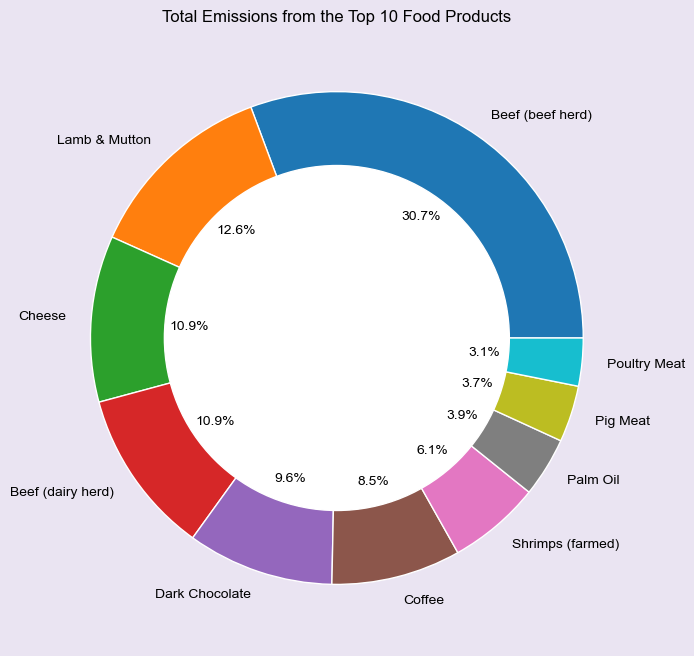

In [58]:
# Group by food product and calculate total emissions for top 10 products
df_top10_emm = df.groupby(['Food_Product'])['Total_Emissions'].sum().sort_values(ascending=False).head(10)

# Calculate percentage of total emissions from top 10 products
diff_top10 = round(((df_top10_emm.sum()/df['Total_Emissions'].sum())*100), 1)

labels_10 = df_top10_emm.index
explode_vals= [0.,0,0,0,0,0,0,0,0,0]

fig = plt.figure(figsize=(15,8),facecolor = '#eae4f2')
plt.pie(df_top10_emm, labels=labels_10, autopct='%.1f%%', explode=explode_vals)

donut = plt.Circle((0,0), 0.7, color='white')
p = plt.gcf()
p.gca().add_artist(donut)

plt.title('Total Emissions from the Top 10 Food Products')

print(f"Grand sum of Total_Emissions: {df['Total_Emissions'].sum()}\n" +
     f"Sum of Top 10 Food_Products: {df_top10_emm.sum().round(1)}\n" +
     f"Total Emission percentage of Top 10 Food Products: {round(df_top10_emm.sum()/df['Total_Emissions'].sum()*100, 1)}%")

plt.show()